<table>
    <tr>
        <td><img src="./imagenes/Macc.png" width="400"/></td>
        <td>&nbsp;</td>
        <td>
            <h1 style="color:blue;text-align:left">Inteligencia Artificial</h1></td>
        <td>
            <table><tr>
            <tp><p style="font-size:150%;text-align:center">Notebook 8</p></tp>
            <tp><p style="font-size:150%;text-align:center">El mundo del Wumpus (2/2)</p></tp>
            </tr></table>
        </td>
    </tr>
</table>

---



# Objetivo

En el notebook pasado nos familiarizamos con el desafío de entrar en la caverna del Wumpus a buscar el oro sin morir en el intento. Vimos un agente de reflejo simple, el cual tiene varias virtudes, pero todavía mucho por mejorar. En especial, vimos que es esencial razonar sobre el Mundo del Wumpus. Nuestra herramienta seleccionada para ello fue la lógica proposicional. Mediante ella representamos varios aspectos del mundo y creamos un método para el agente, el cual llamamos `adyacentes_seguras`. En este notebook vamos a utilizar dicho método para transitar la caverna de manera exhaustiva. También incluiremos la idea de usar proposiciones, llamadas *fluentes*, para representar aspectos cambiantes del mundo. Dotado de esta potente herramienta, el agente podrá salir airoso de muchísimos más escenarios posibles en el desafío del Mundo del Wumpus.

Adaptado de Russell & Norvig (2016), cap. 7.

# Secciones

En este notebook desarrollaremos los siguientes aspectos del problema:

* [Transitando por las casillas seguras.](#seguras)
* [Agente híbrido v. 1.0.](#hybrid)
* [Representando aspectos cambiantes del mundo (fluentes).](#fluentes)


# Transitando por las casillas seguras <a class="anchor" id="seguras"></a>

Recordemos que estamos usando un descriptor para representar situaciones mediante átomos de la lógica proposicional. Repetimos aquí la codificación que usamos en el notebook pasado por conveniencia:

| Información | Número de codificación |
| :---: | :---: |
| Sabe que casilla es segura     | 0    |
| Siente brisa en casilla     | 1 |
| Sabe que hay pozo en casilla  | 2 |
| Siente hedor en casilla     | 3 |
| Sabe que el Wumpus está en casilla     | 4 |

Ahora vamos a cargar las librerías requeridas y a crear el descriptor:

In [1]:
from logica import *
from wumpus import *

In [2]:
informacion = ['es segura', 'brisa en', 'hay un pozo en',
              'hedor en', 'hay Wumpus en']
filas = ['0', '1', '2', '3']
columnas = ['0', '1', '2', '3']
Ninfo = len(informacion)
Nfilas = len(filas)
Ncolumnas = len(columnas)
IenCasilla = Descriptor([Ncolumnas, Nfilas, Ninfo])
W = Wumpus(wumpus=(0,1), oro=(3,2), pozos=[(1,0)])
agente = Agente(W, descriptor=IenCasilla)

También debemos importar las fórmulas que representan la dinámica del mundo:

In [3]:
formulas_brisa = agente.crear_formulas_brisa()
formulas_hedor = agente.crear_formulas_hedor()
formulas_segura = agente.crear_formulas_segura()
formulas_un_wumpus = agente.crear_formulas_un_wumpus()
formulas_hedor_wumpus = agente.crear_formulas_hedor_wumpus()

## Agente basado en un modelo del mundo

En el notebook pasado consideramos un agente reflejo simple. Ahora que podemos representar situaciones del Mundo del Wumpus podemos pasar a una arquitectura más compleja, que se llama *agente basado en un modelo*. (*model-based agent*). La siguiente imagen presenta un esquema de este tipo de agente:

<img src="./imagenes/model-based1.png" width="400">

Para implementar un programa de este tipo, vamos a hacer un par de mejoras sobre el agente de reflejo simple del notebook pasado. Estas son:

* Usar los métodos `make_percept_sentence` y `TELL` para ir actualizando los datos en la base de conocimiento.
* Usar el método `adyacentes_seguras`, el cual nos permite razonar sobre cuáles casillas adyacentes es seguro visitar.
* Escoger aleatoriamente una de las casillas adyacentes que sean seguras y que no haya visitado.
* Deambular por las casillas seguras si no tiene nada mejor que hacer, hasta volver a la salida (e irse con el rabo entre las piernas). 

El siguiente código implementa estas ideas:

In [4]:
def programa_model_based(self):
    
    global casillas_visitadas
    
    # Marca la casilla actual como visitada
    casilla_actual = self.mundo.heroe
    if casilla_actual not in casillas_visitadas:
        casillas_visitadas.append(casilla_actual)
    
    # Actualiza la base de conocimiento con la percepción actual
    percept_sentence = self.make_percept_sentence()
    self.base_conocimiento.TELL(percept_sentence)
    
    # Usa base de conocimiento para encontrar casillas seguras
    casillas_seguras = self.adyacentes_seguras() 

    acciones = []
    percepcion = self.percibir()
    if 'brillo' in percepcion:
        acciones.append('agarrar')
    elif self.mundo.heroe == (0,0) and self.mundo.oro_tomado:
        acciones.append('salir')
    else:
        opciones = [casilla for casilla in casillas_seguras if casilla not in casillas_visitadas]
        if len(opciones) > 0:
            casilla = choice(opciones)
            camino = [casilla_actual, casilla]
            acciones = acciones_camino(camino, self.mundo.direccion)
        elif len(casillas_seguras) > 0:
            casilla = choice(casillas_seguras)
            camino = [casilla_actual, casilla]
            acciones = acciones_camino(camino, self.mundo.direccion)
        elif self.mundo.heroe == (0,0):
            acciones.append('salir')
        else:
            print("¡Caso no contemplado!")
    return acciones

setattr(Agente, "programa", programa_model_based)

Veamos el funcionamiento del agente en un par de escenarios:

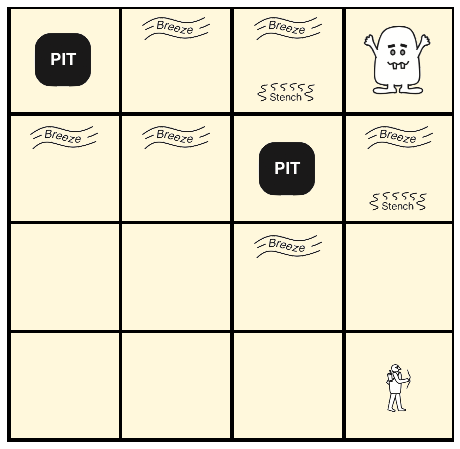

In [5]:
from time import sleep
from IPython.display import clear_output

W = Wumpus(wumpus=(3,3), oro=(1,2), pozos=[(0,3), (2,2)])
W.pintar_todo()
formulas = formulas_brisa + formulas_hedor + formulas_segura + formulas_un_wumpus + formulas_hedor_wumpus
agente = Agente(W, descriptor=IenCasilla, base_conocimiento=LPQuery(formulas))
percept_sentence = agente.make_percept_sentence()
agente.base_conocimiento.TELL(percept_sentence)
casillas_visitadas = []
max_turnos = 50
acciones = []
for t in range(max_turnos):
    sleep(.25)
    clear_output(wait=True)
    if len(acciones) > 0:
        accion = acciones.pop(0)
    else:
        acciones = agente.programa()
        accion = acciones.pop(0)
    W.transicion(accion)
    if not W.juego_activo:
        clear_output(wait=True)
        print(W.mensaje)
        break
    W.pintar_todo()
    plt.show()

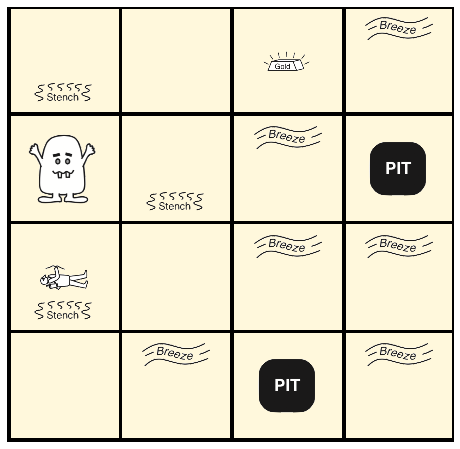

In [6]:
from time import sleep
from IPython.display import clear_output

W = Wumpus(wumpus=(0,2), oro=(2,3), pozos=[(2,0), (3,2)])
W.pintar_todo()
formulas = formulas_brisa + formulas_hedor + formulas_segura + formulas_un_wumpus + formulas_hedor_wumpus
agente = Agente(W, descriptor=IenCasilla, base_conocimiento=LPQuery(formulas))
percept_sentence = agente.make_percept_sentence()
agente.base_conocimiento.TELL(percept_sentence)
casillas_visitadas = []
max_turnos = 2
acciones = []
for t in range(max_turnos):
    sleep(.25)
    clear_output(wait=True)
    if len(acciones) > 0:
        accion = acciones.pop(0)
    else:
        acciones = agente.programa()
        accion = acciones.pop(0)
    W.transicion(accion)
    if not W.juego_activo:
        clear_output(wait=True)
        print(W.mensaje)
        break
    W.pintar_todo()
    plt.show()

**Ejercicio 1:**

Haga una tabla con una columna para las fortalezas y otra para las falencias del agente.

| Fortalezas | Falencias |
| :---: | :---: |
| Evita los pozos y el Wumpus | Una vez tomado el oro, no sale derecho a la casilla de salida |
| Dado suficiente tiempo, explora todas las casillas seguras | El Wumpus le bloquea el camino |
| Puede recuperar el oro y salir en más escenarios que el agente de reflejo simple | Hay situaciones sobre las cuales no puede razonar |

---

Es importante considerar el problema con el segundo escenario. El error ocurrió en alguna de dos posibles circunstancias, dependiendo de si el agente se movió arriba o a la derecha:

<table>
  <tr>
    <td><img src="./imagenes/Problema-arriba.png" width="400"></td>
    <td><img src="./imagenes/Problema-derecha.png" width="400"></td>
  </tr>
</table>

No obstante, en ambos casos el problema es el mismo. Este radica en que el agente llegó a una casilla desde la cual no se puede inferir que alguna de sus casillas adyacentes sea segura. En efecto, preguntémosle al agente sobre qué casillas adyacentes considera seguras mediante el método `adyacentes_seguras`:

In [7]:
agente.adyacentes_seguras()

[]

Observe que nos falta la siguiente información. El agente comienza en la casilla inicial. En este escenario, en dicha casilla no había ni hedor ni brisa, por lo que el agente debería saber que dicha casilla es segura. Esto se puede generalizar aún mas, toda vez que **si el agente no ha muerto estando en una casilla, entonces dicha casilla es segura**. La casilla inicial es sólo un caso particular de esta idea.

Vamos a incorporar este razonamiento en el método `make_percept_sentence`. Además de la información perceptual, incluiremos la información de que la casilla que estamos percibiendo no tiene un pozo ni al Wumpus.

**Ejercicio 2:**

Modifique el método `make_percept_sentence` para incluir la información de que la casilla actual no contiene un pozo ni al Wumpus.

In [8]:
def make_percept_sentence(self):
    # Crea una conjuncion de literales para añadir a la base de datos
    literales = ''
    x, y = self.mundo.heroe
    percepciones = self.percibir()
    if 'brisa' in percepciones:
        literales = self.cods.P([x, y, 1])
    else:
        literales = '-' + self.cods.P([x, y, 1])
    if 'hedor' in percepciones:
        literales += 'Y' + self.cods.P([x, y, 3])
    else:
        literales += 'Y-' + self.cods.P([x, y, 3])
    literales += 'Y-' + self.cods.P([x, y, 2])
    literales += 'Y-' + self.cods.P([x, y, 4])

    return literales

setattr(Agente, "make_percept_sentence", make_percept_sentence)

Pruebe su implementación con la siguiente celda:

El agente siente brisa en la casilla (1,0)
El agente no siente hedor en la casilla (1,0)
El agente sabe que no hay un pozo en la casilla (1,0)
El agente sabe que no hay Wumpus en la casilla (1,0)


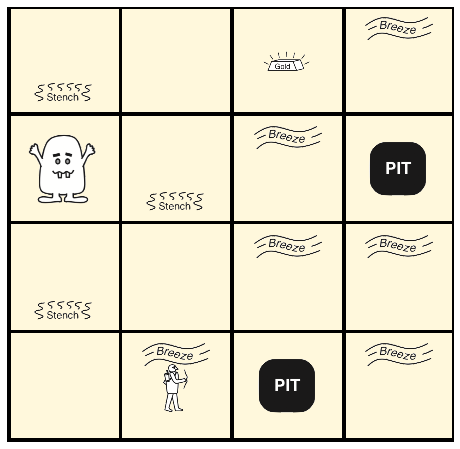

In [9]:
W = Wumpus(wumpus=(0,2), oro=(2,3), pozos=[(2,0), (3,2)])
formulas = formulas_brisa + formulas_hedor + formulas_segura + formulas_un_wumpus + formulas_hedor_wumpus
agente = Agente(W, descriptor=IenCasilla, base_conocimiento=LPQuery(formulas))
agente.mundo.transicion('adelante')
W.pintar_todo()
info = agente.make_percept_sentence().split('Y')
for a in info:
    print(agente.cods.escribir(a))

La respuesta debe ser:

```
El agente siente brisa en la casilla (1,0)
El agente no siente hedor en la casilla (1,0)
El agente sabe que no hay un pozo en la casilla (1,0)
El agente sabe que no hay Wumpus en la casilla (1,0)
```

---

Veamos el comportamiento del agente con la mejora que acabamos de incluir:

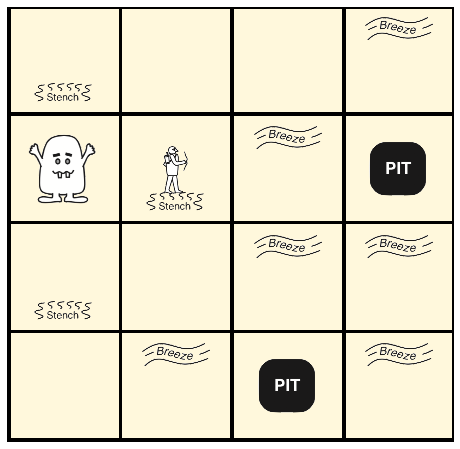

In [10]:
from time import sleep
from IPython.display import clear_output

W = Wumpus(wumpus=(0,2), oro=(2,3), pozos=[(2,0), (3,2)])
W.pintar_todo()
formulas = formulas_brisa + formulas_hedor + formulas_segura + formulas_un_wumpus + formulas_hedor_wumpus
agente = Agente(W, descriptor=IenCasilla, base_conocimiento=LPQuery(formulas))
percept_sentence = agente.make_percept_sentence()
agente.base_conocimiento.TELL(percept_sentence)
casillas_visitadas = []
max_turnos = 50
acciones = []
for t in range(max_turnos):
    sleep(.25)
    clear_output(wait=True)
    if len(acciones) > 0:
        accion = acciones.pop(0)
    else:
        acciones = agente.programa()
        accion = acciones.pop(0)
    W.transicion(accion)
    if not W.juego_activo:
        clear_output(wait=True)
        print(W.mensaje)
        break
    W.pintar_todo()
    plt.show()

El agente logra razonar que, a pesar del hedor en la casilla $(1,2)$, el Wumpus está en $(0,2)$. Esto se logra mediante las reglas discutidas en el ejercicio 9 del notebook anterior. En particular, se usa la regla:

$Hedor(0,1)\wedge\neg Wumpus(0,0)\wedge\neg Wumpus(1,1)\to Wumpus(0,2)$

Al incluir las reglas que indican que sólo hay un Wumpus (ver ejercicio 8 del notebook anterior), el agente puede razonar que, a pesar del hedor en $(1,2)$, el Wumpus no está en las casillas $(1,3)$ o $(2,2)$. Finalmente, gracias a la ausencia de brisa en la casilla $(1,2)$, el agente razona que las casillas $(1,3)$ y $(2,2)$ son seguras. Esto le permite continuar su exploración por la caverna.

## Agente basado en objetivos 

En este punto ya hemos creado muchos de los aspectos más importantes del agente basado en conocimiento. No obstante, aún se requiere un aspecto muy importante de planeación de rutas. Poder diseñar estos planes es esencial para que el agente pueda devolverse a la casilla inicial y salir de la cueva. 

Al incluir la planeación de objetivos en la arquitectura del agente, estamos un paso más arriba en la jerarquía propuesta por Russell & Norvig. En efecto, estamos considerando una arquitectura de *agente basado en objetivos* (*goal-based agent*). La siguiente imagen presenta un esquema de este tipo de arquitectura:

<img src="./imagenes/goal-based.png" width="400">



## Planeación de rutas

Planear una ruta desde la casilla actual hasta una casilla objetivo a la cual se desea ir es un problema muy similar a los que ya hemos encontrado en sesiones pasadas. Debemos definir un ambiente de tarea `Rejilla` y luego usar un algoritmo de búsqueda sobre este.

El ambiente se inicializa con una casilla `actual`, una `objetivo` y una lista de casillas `seguras`. Los aspectos más importantes de la definición formal del ambiente de tarea son los siguientes:

* **acciones_aplicables**(`casilla`): Las casillas adyacentes a `casilla` que estén incluidas en la lista `seguras`.
* **costo**: distancia Manhattan entre las casillas.

**Ejercicio 3:**

Complete la siguiente clase para implementar el ambiente de tarea `Rejilla` y compruebe su código con la siguiente celda.

In [15]:
class Rejilla:
    
    # Problema del tránsito por la rejilla
    # desde donde está el héroe hasta una
    # casilla objetivo
    
    def __init__(self, actual, objetivo, seguras):
        self.estado_inicial = actual
        self.estado_objetivo = objetivo
        self.casillas_seguras = seguras
    
    def acciones_aplicables(self, estado):
        return [casilla for casilla in adyacentes(estado) if casilla in self.casillas_seguras]
    
    def transicion(self, estado, accion):
        return accion
       
    def test_objetivo(self, estado):
        return estado == self.estado_objetivo
    
    def costo(self, estado, accion):
        x1, y1 = estado
        x2, y2 = self.transicion(estado, accion)
        return abs(x1-x2) + abs(y1-y2)
        
    def codigo(self, estado):
        x, y = estado
        return f"{x}-{y}"


In [16]:
from busqueda import *

seguras = [(x, y) for x in range(4) for y in range(4)]
R = Rejilla((3,2), (0,0), seguras)
camino = best_first_search(R)
camino = solucion(camino)
print(camino)

[(2, 2), (1, 2), (1, 1), (0, 1), (0, 0)]


La respuesta debe ser:

```
[(2, 2), (1, 2), (1, 1), (0, 1), (0, 0)]
```

---

**Ejercicio 4:**

Ahora necesitamos encontrar todas las casillas seguras que conozcamos hasta el momento. Implemente el método `todas_segura` para la clase `Agente` y pruébelo con la siguiente celda.

In [19]:
def todas_seguras(self):
    casillas_seguras = []
    pass

setattr(Agente,"todas_seguras",todas_seguras)

In [18]:
W = Wumpus(wumpus=(0,2), oro=(2,3), pozos=[(2,0), (3,2)])
formulas = formulas_brisa + formulas_hedor + formulas_segura + formulas_un_wumpus + formulas_hedor_wumpus
agente = Agente(W, descriptor=IenCasilla, base_conocimiento=LPQuery(formulas))
percept_sentence = agente.make_percept_sentence()
agente.base_conocimiento.TELL(percept_sentence)
agente.mundo.transicion('voltearIzquierda')
agente.mundo.transicion('adelante')
percept_sentence = agente.make_percept_sentence()
agente.base_conocimiento.TELL(percept_sentence)
agente.mundo.transicion('voltearDerecha')
agente.mundo.transicion('adelante')
percept_sentence = agente.make_percept_sentence()
agente.base_conocimiento.TELL(percept_sentence)
agente.mundo.transicion('voltearIzquierda')
agente.mundo.transicion('adelante')
percept_sentence = agente.make_percept_sentence()
agente.base_conocimiento.TELL(percept_sentence)
print(agente.todas_seguras())

None


La respuesta debe ser:

```
[(0, 0), (0, 1), (1, 0), (1, 1), (1, 2), (1, 3), (2, 1), (2, 2)]
```

---

# Agente híbrido v. 1.0 <a class="anchor" id="hybrid"></a>

Ya estamos listos para incorporar la búsqueda de objetivos, para que el agente vaya a la salida tan pronto encuentre el oro. Las modificaciones más importantes son las siguientes:

* Tan pronto toma el oro, el agente planea una ruta segura hasta la salida.
* Selecciona una casilla segura en toda la rejilla (no solo aquellas adyacentes), y planea una ruta segura para visitarla.
* Si no hay opciones seguras para visitar, planea una ruta segura hasta la salida.

El siguiente código implementa estas ideas:

In [ ]:
def programa_goal_based(self):
    
    global casillas_visitadas
    
    # Marca la casilla actual como visitada
    casilla_actual = self.mundo.heroe
    if casilla_actual not in casillas_visitadas:
        casillas_visitadas.append(casilla_actual)
    
    # Actualiza la base de conocimiento con la percepción actual
    percept_sentence = self.make_percept_sentence()
    self.base_conocimiento.TELL(percept_sentence)
        
    # Usa base de conocimiento para encontrar casillas seguras
    casillas_seguras = self.todas_seguras()

    acciones = []
    percepcion = self.percibir()
    
    # Si ve el oro, lo toma y planea un camino hasta la salida
    if 'brillo' in percepcion:
        print("¡Veo el oro!")
        acciones = ['agarrar']
        R = Rejilla(casilla_actual, (0,0), casillas_seguras)
        camino = best_first_search(R)
        camino = [casilla_actual] + solucion(camino)
        acciones += acciones_camino(camino, self.mundo.direccion)
        
    # Si está en la salida y tiene el oro, salir
    elif self.mundo.heroe == (0,0) and self.mundo.oro_tomado:
        acciones.append('salir')
    else:
        
        # Escoje una casilla segura no visitada para ir
        opciones = [casilla for casilla in casillas_seguras if casilla not in casillas_visitadas]
        if len(opciones) > 0:
#            print("Modo exploración...")
#            print("Voy a", casilla)
            casilla = choice(opciones)
            R = Rejilla(casilla_actual, casilla, casillas_seguras)
            camino = best_first_search(R)
            camino = [casilla_actual] + solucion(camino)
            acciones += acciones_camino(camino, self.mundo.direccion)
        
        # No hay opciones seguras para visitar, así que planea
        # un camino hasta la salida
        else:
#            print("¡Mejor me voy!")
            R = Rejilla(casilla_actual, (0,0), casillas_seguras)
            camino = best_first_search(R)
            camino = [casilla_actual] + solucion(camino)
            acciones += acciones_camino(camino, self.mundo.direccion)            
            acciones.append('salir')
    return acciones

setattr(Agente, "programa", programa_goal_based)

Verifiquemos el funcionamiento en un par de escenarios:

In [ ]:
from time import sleep
from IPython.display import clear_output

W = Wumpus(wumpus=(3,3), oro=(3,2), pozos=[(0,3), (2,2)])
W.pintar_todo()
formulas = formulas_brisa + formulas_hedor + formulas_segura + formulas_un_wumpus + formulas_hedor_wumpus
agente = Agente(W, descriptor=IenCasilla, base_conocimiento=LPQuery(formulas))
percept_sentence = agente.make_percept_sentence()
agente.base_conocimiento.TELL(percept_sentence)
casillas_visitadas = []
max_turnos = 500
acciones = []
for t in range(max_turnos):
    sleep(.25)
    clear_output(wait=True)
    if len(acciones) > 0:
        accion = acciones.pop(0)
    else:
        acciones = agente.programa()
        accion = acciones.pop(0)
    W.transicion(accion)
    if not W.juego_activo:
        clear_output(wait=True)
        print(W.mensaje)
        break
    W.pintar_todo()
    plt.show()

In [ ]:
from time import sleep
from IPython.display import clear_output

W = Wumpus(wumpus=(0,2), oro=(2,3), pozos=[(2,0), (3,2)])
W.pintar_todo()
formulas = formulas_brisa + formulas_hedor + formulas_segura + formulas_un_wumpus + formulas_hedor_wumpus
agente = Agente(W, descriptor=IenCasilla, base_conocimiento=LPQuery(formulas))
percept_sentence = agente.make_percept_sentence()
agente.base_conocimiento.TELL(percept_sentence)
casillas_visitadas = []
max_turnos = 500
acciones = []
for t in range(max_turnos):
    x, y = agente.mundo.heroe
    segura = agente.cods.P([x,y,0])
    agente.base_conocimiento.TELL(segura)
    sleep(.25)
    clear_output(wait=True)
    if len(acciones) > 0:
        accion = acciones.pop(0)
    else:
        acciones = agente.programa()
        accion = acciones.pop(0)
    W.transicion(accion)
    if not W.juego_activo:
        clear_output(wait=True)
        print(W.mensaje)
        break
    W.pintar_todo()
    plt.show()

In [ ]:
from time import sleep
from IPython.display import clear_output

W = Wumpus(wumpus=(0,2), oro=(2,3), pozos=[(2,0), (2,2)])
W.pintar_todo()
formulas = formulas_brisa + formulas_hedor + formulas_segura + formulas_un_wumpus + formulas_hedor_wumpus
agente = Agente(W, descriptor=IenCasilla, base_conocimiento=LPQuery(formulas))
percept_sentence = agente.make_percept_sentence()
agente.base_conocimiento.TELL(percept_sentence)
casillas_visitadas = []
max_turnos = 500
acciones = []
for t in range(max_turnos):
    x, y = agente.mundo.heroe
    segura = agente.cods.P([x,y,0])
    agente.base_conocimiento.TELL(segura)
    sleep(.25)
    clear_output(wait=True)
    if len(acciones) > 0:
        accion = acciones.pop(0)
    else:
        acciones = agente.programa()
        accion = acciones.pop(0)
    W.transicion(accion)
    if not W.juego_activo:
        clear_output(wait=True)
        print(W.mensaje)
        break
    W.pintar_todo()
    plt.show()

Observe que el agente no encuentra por donde pasar, toda vez que los pozos y el Wumpus bloquean el camino hasta el oro. Una manera (poco humanitaria) de continuar la exploración de la caverna consiste en dispararle al Wumpus, de tal manera que se abra una nueva rejilla. Para implementar esto también usaremos lógica proposicional, pero debemos hacer una consideración importante, para incorporar los aspectos variables del mundo.

# Representando aspectos cambiantes del mundo (fluentes) <a class="anchor" id="fluentes"></a>

Hasta este punto la base de conocimiento contiene información sobre las reglas concernientes a los aspectos estáticos del mundo, pero es importante considerar aquellos aspectos cambiantes de este. Por ejemplo, el hecho de que el Wumpus esté vivo o no debe manejarse con cuidado, pues es esencialmente distinto al hecho de que en la casilla haya un pozo o una brisa. Estos últimos hechos no cambian su valor de verdad conforme el héroe interactúa con el entorno. No obstante, el hecho de que el Wumpus esté vivo cambia cuando el agente le acierta con una flecha (pobre Wumpus). Esto genera una dificultad cuando la toma de decisiones se hace mediante la base de conocimiento, como lo consideramos en el presente caso.

Observe que para la toma de decisiones es importante la información de que el Wumpus está vivo. Sin embargo, si esta información fuera almacenada como un literal estático, entonces una vez el agente incluya en su base de conocimiento que el Wumpus está vivo, siempre considerará que así es. Pero después de disparar, el mundo cambia y, por tanto, también deberá hacerlo nuestra base de conocimiento.

Para solucionar este inconveniente, el hecho de que el Wumpus esté vivo debe representarse mediante un *fluente*. Fluente, del latin *fluens* (fluyendo), es una manera "fancy" de referirse a átomos indexados por un índice temporal. 

## Codificación de fluentes

Los fluentes requieren de un índice temporal, lo cual implica que debemos crear una codificación que cruce el índice temporal con la información sobre la cual versa el átomo, sin que esta codificación entre en conflicto con la codificación de los hechos estáticos. Para ello, debemos crear un nuevo descriptor, el cual cruzará solo dos tipos de información: el aspecto del mundo y el turno. Utilizaremos la siguiente codificación de los aspectos del mundo:

| Fluente | Número de codificación |
| :---: | :---: |
| TenerFlecha     | 0 |
| Disparar     | 1 |
| Gemido     | 2 |
| WumpusVivo     | 3 |
| Brillo     | 4    |
| Agarrar     | 5 |

La siguiente es una implementación de este nuevo descriptor:

In [20]:
fluentes = ['TenerFlecha', 'Disparar', 'Gemido' , 'WumpusVivo', 'Brillo', 'Agarrar']
Nfluentes = len(fluentes)
max_iteraciones = 500
letras_desde = IenCasilla.rango[1] + 1
fluente = Descriptor([Nfluentes,max_iteraciones],chrInit=letras_desde)

También debemos crearle su propio método de escritura:

In [21]:
def escribir(self, literal):
    if '-' in literal:
        atomo = literal[1:]
        neg = chr(172)
    else:
        atomo = literal
        neg = ''
    x, t = self.inv(atomo)
    return f"{neg}{fluentes[x]}{t}"

from types import MethodType
fluente.escribir = MethodType(escribir, fluente)

In [22]:
f = '-' + fluente.P([5,0])
fluente.escribir(f)

'¬Agarrar0'

**Ejercicio 5:**

Cree los siguientes fluentes:

* El agente tiene la flecha en el turno 0
* El agente dispara la flecha en el turno 0
* El agente no tiene la flecha en el turno 1

La respuesta debe ser:

```
ő
-ŗ
Œ
```

In [28]:
f = fluente.P([0,0])
g = fluente.P([1,0])
h = '-' + fluente.P([0,1])
print(f,g,h)

ő Œ -ŗ


---

Para hacernos la vida más fácil a la hora de visualizar una fórmula, vamos a usar la función `regla_en_palabras`, definida a continuación. Observe que si queremos poner en palabras un átomo, usamos más bien la función `en_palabras`.

In [29]:
def regla_en_palabras(regla):
    r = ClausulaDefinida(regla)
    inicial = True
    for l in r.cuerpo:
        if inicial:
            cu = en_palabras(l)
            inicial = False
        else:
            cu += ' Y ' + en_palabras(l)
    return cu + ' > ' + en_palabras(r.cabeza)

def en_palabras(literal):
    tipo = tipo_atomo(literal)
    if tipo == 'Estático':
        return IenCasilla.escribir(literal)
    elif tipo == 'Fluente':
        return fluente.escribir(literal)
    
def tipo_atomo(literal):
    if '-' in literal:
        atomo = literal[1:]
    else:
        atomo = literal
    n = ord(atomo)
    if n in range(*IenCasilla.rango):
        return 'Estático'
    elif n in range(*fluente.rango):
        return 'Fluente'
    


In [30]:
e = '-' + IenCasilla.P([0,0,0])
f = '-' + fluente.P([0,0])
print('Caracter:', e)
print('Tipo de átomo:', tipo_atomo(e))
print('Átomo en palabras:', en_palabras(e))
print('')
print('Caracter:', f)
print('Tipo de átomo:', tipo_atomo(f))
print('Átomo en palabras:', en_palabras(f))
regla = e + '>' + f
print('')
print(regla_en_palabras(regla))

Caracter: -Ā
Tipo de átomo: Estático
Átomo en palabras: El agente sabe que no es segura la casilla (0,0)

Caracter: -ő
Tipo de átomo: Fluente
Átomo en palabras: ¬TenerFlecha0

El agente sabe que no es segura la casilla (0,0) > ¬TenerFlecha0


## Axiomas de estado sucesor


Para representar el valor de los aspectos que cambian en distintos estados de tiempo usamos fluentes. La manera correcta de controlar el cambio de valor de estos aspectos es mediante axiomas de estado sucesor (*succesor-state axioms*). Estos determinan el valor de un fluente en un tiempo $t+1$ con respecto al valor del fluente en el tiempo $t$ y la ejecución de alguna acción o acciones. Por ejemplo, considere el siguiente fluente:

(1) $TenerFlecha_t$ es verdadero sii el agente está en posesión de su flecha en el instante de tiempo $t$.

El valor de este fluente en el tiempo $t+1$ depende de su valor en el tiempo $t$ y de si el agente dispara la flecha en el tiempo $t$. De esta manera, podemos escribir el siguiente axioma para controlar el fluente $TenerFlecha$:

(2) $\Bigl(TenerFlecha_t\wedge\neg Disparar_t\Bigr)\leftrightarrow TenerFlecha_{t+1}$

Observe que la fórmula (2) no hace parte del fragmento de lógica proposicional que estamos considerando. En consecuencia, debemos cambiarla por varias reglas que en conjunto sean equivalentes. En este caso, (2) es equivalente a tener (3), (4) y (5):

(3) $TenerFlecha_t\wedge\neg Disparar_t\to TenerFlecha_{t+1}$

(4) $\neg TenerFlecha_t\to \neg TenerFlecha_{t+1}$

(5) $Disparar_t\to \neg TenerFlecha_{t+1}$



**Ejercicio 6:**

Implemente una función que, dado un tiempo `t`, genere todos los axiomas de estado sucesor para el fluente $TenerFlecha_t$. Compruebe su código con la siguiente celda.

In [31]:
def axiomas_TenerFlecha(t):
    f1 = fluente.P([0,t]) + 'Y-' + fluente.P([1,t]) + '>' + fluente.P([0,t+1])
    f2 = '-' + fluente.P([0,t]) + '>-' + fluente.P([0,t+1])
    f3 = fluente.P([1,t]) + '>-' + fluente.P([0,t+1])
    return [f1, f2, f3]

In [ ]:
ax_f = axiomas_TenerFlecha(0)
for r in ax_f:
    print(regla_en_palabras(r))

La respuesta debe ser:

```
TenerFlecha0 Y ¬Disparar0 > TenerFlecha1
¬TenerFlecha0 > ¬TenerFlecha1
Disparar0 > ¬TenerFlecha1
```

**Ejercicio 7:**

Implemente una función que, dado un tiempo $t$, genere el axioma de estado sucesor correspondiente a (1). Observe que lo que debe implementar son las reglas en (2), (3) y (4).


(1) $\Bigl(WumpusVivo_t\wedge\neg Gemido_t\Bigr)\leftrightarrow WumpusVivo_{t+1}$

(2) $WumpusVivo_t\wedge\neg Gemido_t\to WumpusVivo_{t+1}$

(3) $\neg WumpusVivo_\to \neg WumpusVivo_{t+1}$

(4) $Gemido_t\to \neg WumpusVivo_{t+1}$

**Ejercicio 8:**

Considere el axioma de estado sucesor (1), correspondiente al fluente $Brillo$:

(1) $Brillo_{t+1} \leftrightarrow \Bigl(Brillo_t \wedge \neg Agarrar_t \Bigr)$

* Escriba las reglas correspondientes a (1).
* Implemente una función que, dado un tiempo $t$, genere las reglas correspondientes al axioma de estado sucesor correspondiente a (1).


**Ejercicio 9:**

Crear un plan para asesinar al Wumpus cuando se sabe su ubicación y está vivo y se tiene flecha.

**Ejercicio 10:**

Modifique el programa de agente para nunca usar percepciones (lo único que se debe usar es el método `make_percept_sentence`). Observe que debe crear una función que cree los átomos correspondientes a las acciones relevantes, para poder llevar un registro de los fluentes en la base de conocimiento.

---

### En este notebook usted aprendió

* Encontrar las casillas seguras para transitar.
* Diseñar un plan para ir de la casilla actual a una casilla objetivo.
* Fluentes y el aspecto dinámico del mundo.
* Toma de decisiones y planeación para superar el mundo del Wumpus.